In [8]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
gamma = 7/5
def generateB(u0, rho, gamma, p):
    B = np.array([
        u0, rho, zero_vec, zero_vec, 
        zero_vec, u0, zero_vec, 1/rho, 
        zero_vec, zero_vec, u0, zero_vec, 
        zero_vec, gamma * p, zero_vec, u0
    ])
    return B
    
def numerical_flux(rho, u, v, p, e):
    flux = np.array([rho * u, rho*u**2 + p, rho * u * v, u * (e + p)])
    return flux
def speed_extimate(Q1,Q2):
    rho_i,u_i, v_i, e_i,p_i = CalcVar(Q1)
    rho_i1,u_i1, v_i1, e_i1, p_i1 = CalcVar(Q2)
    const = np.sqrt(rho_i) + np.sqrt(rho_i1)
    tilde_u = (np.sqrt(rho_i) * u_i + np.sqrt(rho_i1) * u_i1)/const
    Hi = (e_i + p_i)/rho_i
    Hi1 = (e_i + p_i)/rho_i
    tilde_H = (np.sqrt(rho_i) * Hi + np.sqrt(rho_i1)*Hi1)/const
    tilde_a = np.sqrt((gamma - 1) * (tilde_H - 1/2 * tilde_u))
    LL = tilde_u - tilde_a
    LR = tilde_u + tilde_a
    return LL, LR

def eigen_val(gamma, u, p, rho):
    c = np.sqrt(gamma * p / rho)
    eig1 = u - c
    eig2 = u
    eig3 = u + c
    return eig1, eig2, eig3
    
def lambda_star(LR,LL,rho_i1, u_i1, rho_i, u_i,p_i1, p_i):
    fz = LR * rho_i1 * u_i1 - LL * rho_i * u_i - (rho_i1 * u_i1**2 + p_i1 - rho_i * u_i**2 - p_i)
    fm = LR * rho_i1 - LL * rho_i - (rho_i1 * u_i1 - rho_i * u_i)
    lam_star = fz / fm
    return lam_star

def QL_star(LL, LS, u_i, rho_i, e_i, p_i, v_i):
    rhoL_star = (LL - u_i) * rho_i/(LL - LS)
    eL_star = (LL - u_i)*e_i/(LL - LS) + (LS - u_i) * p_i/(LL - LS) + rho_i*LS*(LS - u_i)*(LL - u_i)/(LL - LS)
    QL = np.array([[rhoL_star, rhoL_star*LS, rhoL_star *v_i, eL_star]]).T
    return QL

def QR_star(LR, LS, u_i1, rho_i1, e_i1, p_i1, v_i1):
    rhoR_star = (LR - u_i1) * rho_i1/(LR - LS)
    eR_star = (LR - u_i1)*e_i1/(LR - LS) + (LS - u_i1) * p_i1/(LR - LS) + rho_i1*LS*(LS - u_i1)*(LR - u_i1)/(LR - LS)
    QR = np.array([[rhoR_star, rhoR_star*LS, rhoR_star *v_i1, eR_star]]).T
    return QR
    
def CalcVar(Q):
    r1 = Q[0]
    u = Q[1]/r1
    v = Q[2]/r1
    e = Q[3]
    p = (e - 1/2 * r1 *(u**2 + v**2)) * (gamma - 1)
    return r1, u, v, e, p
    
def Compute_Scheme_Flux(Q1, Q2, speed_method = 'EXTEgen'):
    
    rho_i,u_i, v_i, e_i,p_i = CalcVar(Q1)
    rho_i1,u_i1, v_i1, e_i1, p_i1 = CalcVar(Q2)
    if speed_method == 'AVEgen':
        LL, LR = speed_extimate(Q1, Q2)
    if speed_method == 'EXTEgen':
    
        ci = np.sqrt(gamma * p_i/rho_i)
        ci1 = np.sqrt(gamma * p_i1/rho_i1)

        LL = np.minimum(u_i - ci, u_i1 - ci1)
        LR = np.maximum(u_i + ci, u_i1 + ci1)
    LS = lambda_star(LR, LL,rho_i1, u_i1, rho_i, u_i,p_i1, p_i)
    
    if LL >= 0:
        NumeF = numerical_flux(rho_i, u_i, v_i, p_i, e_i)
        
    if (LL < 0) and (LS > 0):
        QL_S = QL_star(LL, LS, u_i, rho_i, e_i, p_i, v_i).flatten()
        FQi = numerical_flux(rho_i, u_i, v_i, p_i, e_i)
        NumeF = FQi + LL * (QL_S - Q1)
        
    if (LS<=0) and (LR >0):
        QR_S = QR_star(LR, LS, u_i1, rho_i1, e_i1, p_i1, v_i1).flatten()
        FQi = numerical_flux(rho_i1, u_i1, v_i1, p_i1, e_i1)
        NumeF = FQi + LR * (QR_S - Q2)
    
    if LR<=0:
        NumeF = numerical_flux(rho_i1, u_i1, v_i1, p_i1, e_i1)
        
    else:
        
        FQ1 = numerical_flux(rho_i, u_i, v_i, p_i, e_i)
        FQ2 = numerical_flux(rho_i1, u_i1, v_i1, p_i1, e_i1)
        NumeF = (LR * FQ1 - LL * FQ2 + LL * LR *(Q2 - Q1))/(LR - LL)  
        
    return NumeF
def Parse_var(Q):
    r1 = Q[0,:]
    u = Q[1,:]/r1
    v = Q[2,:]/r1
    e = Q[3,:]
    p = (e - 1/2 * r1 *(u**2 + v**2)) * (gamma - 1)
    return r1, u, v, e, p

In [9]:
from tqdm import tqdm
def Numerical_solu(t_f):
    N = int(200 * t_f)
    cn = N
    gamma = 7/5
    x_dist = np.linspace(-2, 2, N)
    rho = np.zeros(N)
    rho[np.where(x_dist<0)] = 1
    rho[np.where(x_dist>0)] = 3
    u0 = np.zeros(N)
    v = np.zeros(N)
    v[np.where(x_dist<0)] = -1
    v[np.where(x_dist>0)] = 1
    p = np.ones(N)
    e = p/(gamma - 1) + 1/2 * rho *(u0**2 + v**2)
    zero_vec = np.zeros(N)
    Q = np.array([rho, rho * u0, rho * v, e])
    Q_init = Q[:,0]
    Q_end = Q[:,-1]
    ts = int(200 * t_f)
    t = np.linspace(0, t_f, ts)
    dt = t_f/ts
    dx = 4/N

    for ti in tqdm(t[1:]):
        N = Q.shape[1]
        for i in range(0, N):
            Q1 = Q[:,i]
            if i == 0:
                Q0 = Q1
            else:
                Q0 = Q[:, i-1]
            if i == N - 1:
                Q2 = Q1
            else:
                Q2 = Q[:,i+1]
            F1 = Compute_Scheme_Flux(Q1, Q2)
            F2 = Compute_Scheme_Flux(Q0, Q1)
            Qnew = (Q1 - dt/dx * (F1 - F2)).reshape(-1,1)
            if i == 0:
                newQ = Qnew
            else:
                newQ = np.concatenate((newQ, Qnew), axis = 1)

        Q = newQ
    r1, u, v, e, p = Parse_var(Q)
    return r1, u, v, e, p, x_dist

In [13]:
def Visual_solu(r1, u, v, e, p, x_s):
    %config InlineBackend.figure_format = 'retina'
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(2, 3, figsize=(12, 6))
    plt.subplot(2,3,1)
    plt.plot(x_s, r1, 'k',label = '$\\rho$')
    plt.legend(loc = 0)
    plt.subplot(2,3,2)
    plt.plot(x_s, u, 'k',label = '$u$')
    plt.legend(loc = 0)
    plt.subplot(2,3,3)
    plt.plot(x_s, v, 'k',label = '$v$')
    plt.legend(loc = 0)
    plt.subplot(2,3,4)
    plt.plot(x_s, e, 'k',label = '$e$')
    plt.legend(loc = 0)
    plt.subplot(2,3,5)
    plt.plot(x_s, p, 'k',label = 'p')
    plt.legend(loc = 0)

    fig.delaxes(axs[1, 2])
    plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:02<00:00, 91.75it/s]


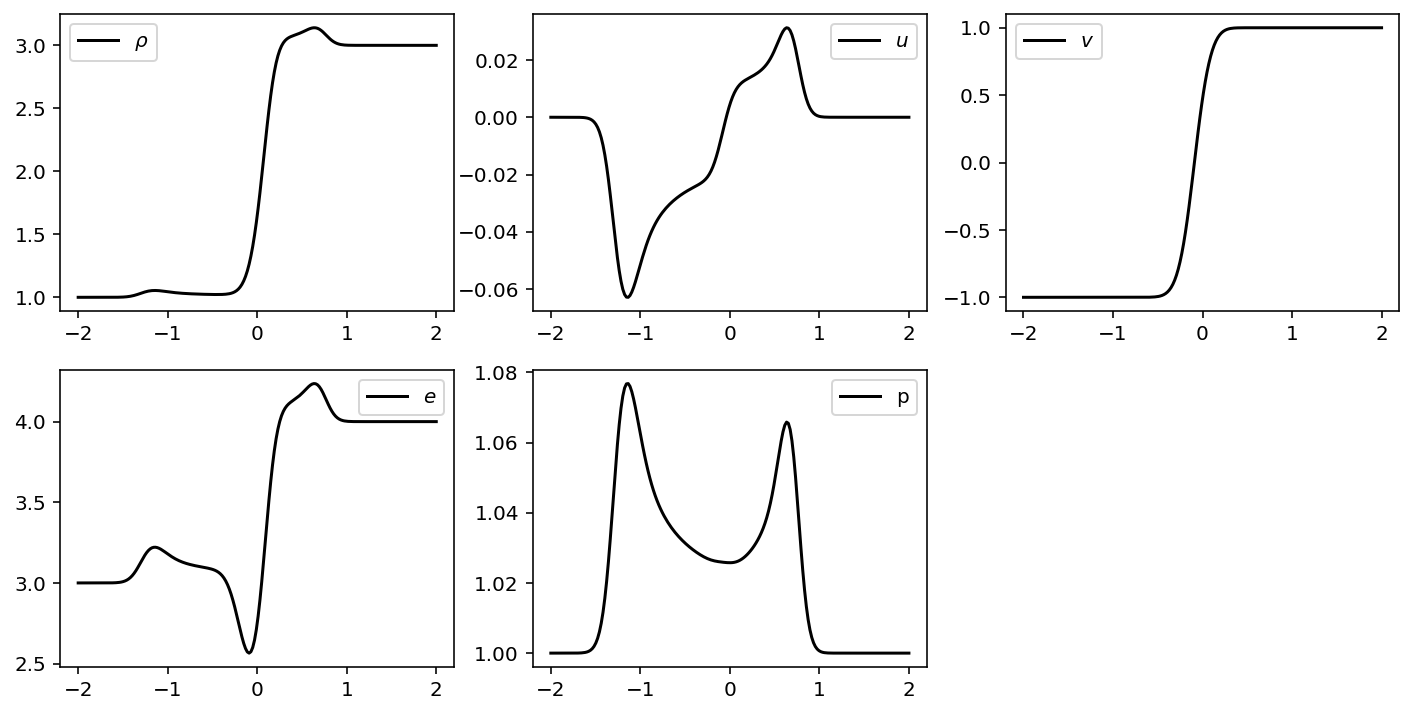

In [15]:
r1, u, v, e, p, x_dist = Numerical_solu(1)
Visual_solu(r1, u, v, e, p, x_dist)

100%|████████████████████████████████████████████████████████████████████████████████| 399/399 [00:09<00:00, 43.60it/s]


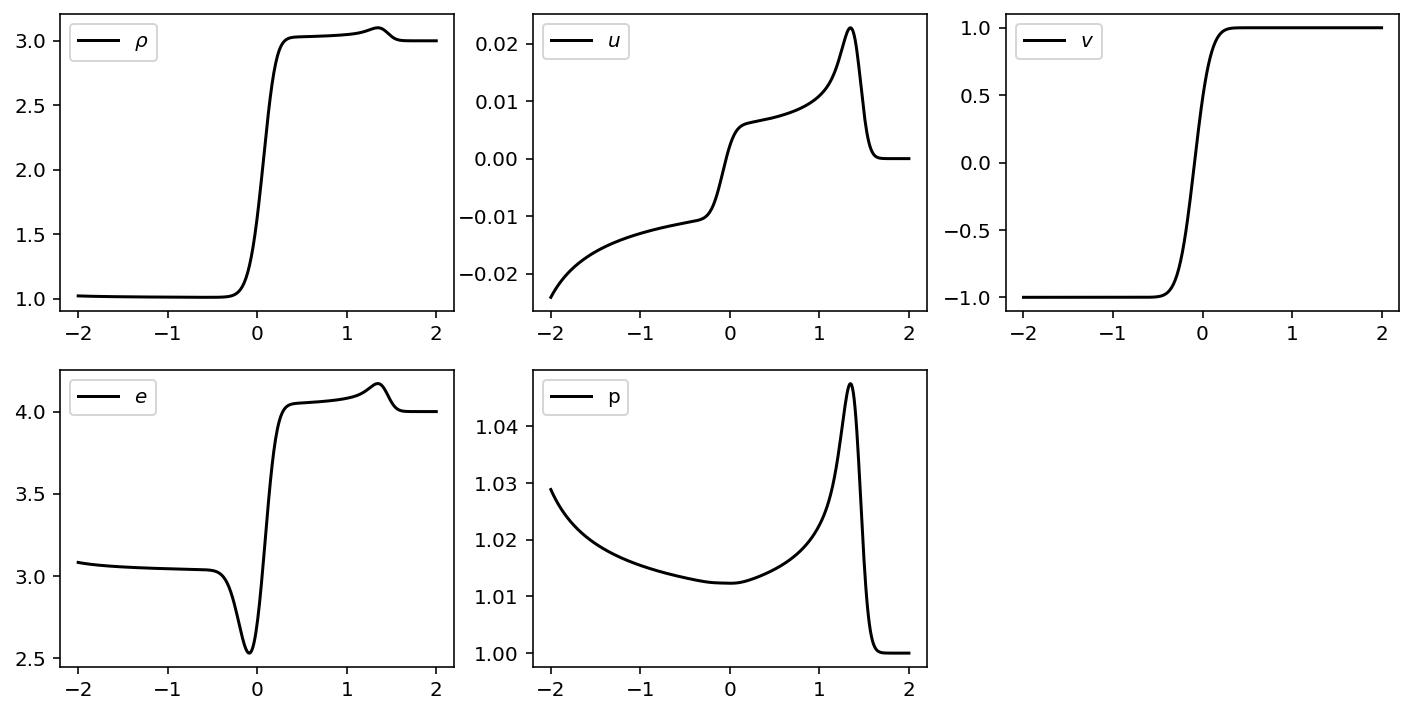

In [16]:
r1, u, v, e, p, x_dist = Numerical_solu(2)
Visual_solu(r1, u, v, e, p, x_dist)

100%|████████████████████████████████████████████████████████████████████████████████| 599/599 [00:20<00:00, 29.38it/s]


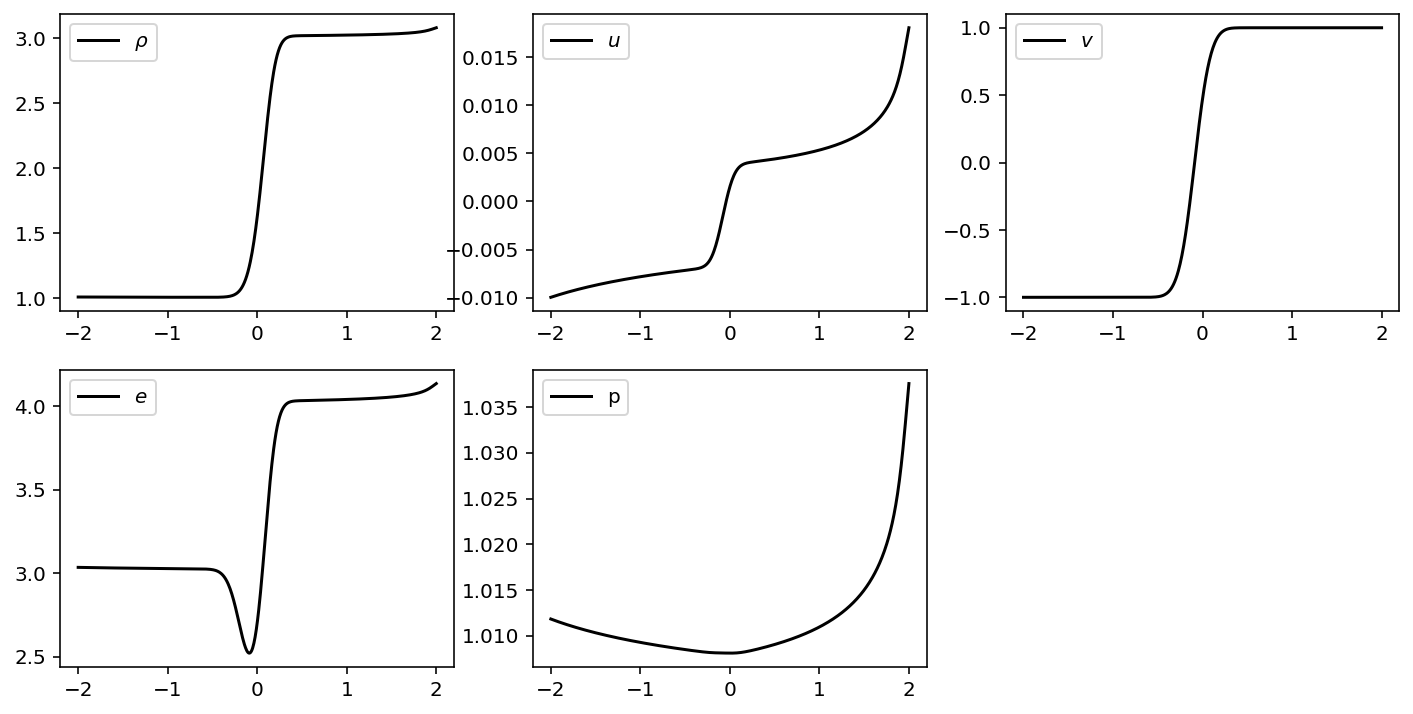

In [17]:
r1, u, v, e, p, x_dist = Numerical_solu(3)
Visual_solu(r1, u, v, e, p, x_dist)